<a href="https://colab.research.google.com/github/aritanaoya/howling_canceler/blob/master/%E3%83%8F%E3%82%A6%E3%83%AA%E3%83%B3%E3%82%AF%E3%82%99%E3%82%AD%E3%83%A3%E3%83%B3%E3%82%BB%E3%83%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##google driveとの連携

In [0]:
import os, shutil

os.getcwd()
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##音声をup

In [0]:
id = '1nlKIc1Y9_lzo28Pm9RYsWx_VX38qWhg5'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('howling_sounds.zip')

In [0]:
id = '1pfqDJw7gAFXM7EguQzvKX3vn0r3VRvrM'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('correct_sounds.zip')

In [4]:
!unzip correct_sounds.zip
!unzip howling_sounds.zip
!ls
!pip install librosa==0.7

Archive:  correct_sounds.zip
   creating: correct_sounds/
  inflating: correct_sounds/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/correct_sounds/
  inflating: __MACOSX/correct_sounds/._.DS_Store  
  inflating: correct_sounds/ford8k_10s.wav  
  inflating: __MACOSX/correct_sounds/._ford8k_10s.wav  
  inflating: correct_sounds/ford8k_30s.wav  
  inflating: __MACOSX/correct_sounds/._ford8k_30s.wav  
  inflating: correct_sounds/ford8k_50s.wav  
  inflating: __MACOSX/correct_sounds/._ford8k_50s.wav  
  inflating: correct_sounds/ford8k_20s.wav  
  inflating: __MACOSX/correct_sounds/._ford8k_20s.wav  
  inflating: correct_sounds/ford8k_40s.wav  
  inflating: __MACOSX/correct_sounds/._ford8k_40s.wav  
  inflating: __MACOSX/._correct_sounds  
Archive:  howling_sounds.zip
   creating: howling_sounds/
  inflating: howling_sounds/ford8k_40s_howling1500out.wav  
   creating: __MACOSX/howling_sounds/
  inflating: __MACOSX/howling_sounds/._ford8k_40s_howling1500out.wav  
  inflating: howl

In [0]:
import os, shutil
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import numpy as np

###現在地と中身の確認

In [17]:
!ls
!pwd

adc.json	correct_sounds.zip  howling_sounds	__MACOSX
correct_sounds	howling_canceller   howling_sounds.zip	sample_data
/content


In [0]:
batch_size = 5
epochs = 10
saveDir = "/content/howling_canceller"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

##音声の読み込み

[6.1035156e-05 2.4414062e-04 4.2724609e-04 ... 2.3498535e-03 6.5917969e-03
 1.1047363e-02]


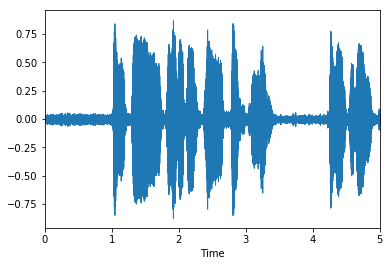

In [102]:

import librosa
import librosa.core as lc  
import numpy as np  
import scipy 
import IPython.display as ipd
import os
import matplotlib.pyplot as plt
import librosa.display



def load_sound_files(parent_dir, file_paths):
    raw_sounds = []
    
    for fp in file_paths:
        y,sr = librosa.load(parent_dir + fp, sr=8000,dtype='float32',duration=5)
        #デフォルトでモノラル化、
        raw_sounds.append(y)
    return raw_sounds
   
correct_sound_file_paths = ["ford8k_10s.wav","ford8k_20s.wav","ford8k_30s.wav","ford8k_40s.wav","ford8k_50s.wav"]
howling_sound_file_paths = ["ford8k_10s_howling2000out.wav","ford8k_20s_howling2000out.wav","ford8k_30s_howling2000out.wav",\
                            "ford8k_40s_howling2000out.wav","ford8k_50s_howling2000out.wav"]
parent_dir = '/content/correct_sounds/'
parent_dir2='/content/howling_sounds/'
correct_sounds=[]
howling_sounds=[]
correct_sounds= load_sound_files(parent_dir,correct_sound_file_paths)
howling_sounds= load_sound_files(parent_dir2,howling_sound_file_paths)

print((howling_sounds[0]))

librosa.display.waveplot(correct_sounds[4], 8000)
#librosa.display.waveplot(howling_sounds[0], 22050)
#ipd.Audio(data=correct_sounds[0],rate=8000)
ipd.Audio(data=howling_sounds[0],rate=8000)

##音声の等間隔の切り取り

In [7]:
"""

import wave
import struct
import math
import os
from scipy import fromstring, int16

# 一応既に同じ名前のディレクトリがないか確認。
file = os.path.exists("output_correct")
print(file)

if file == False:
    #保存先のディレクトリの作成
    os.mkdir("output_correct")

def cut_wav(filename,time):  # WAVファイルを刈り奪る　形をしてるだろ？ 
    # timeの単位は[sec]

    # ファイルを読み出し
    wavf = filename + '.wav'
    wr = wave.open(wavf, 'r')

    # waveファイルが持つ性質を取得
    ch = wr.getnchannels()
    width = wr.getsampwidth()
    fr = wr.getframerate()
    fn = wr.getnframes()
    total_time = 1.0 * fn / fr
    integer = math.floor(total_time) # 小数点以下切り捨て
    t = int(time)  # 秒数[sec]
    frames = int(ch * fr * t)
    num_cut = int(integer//t)

    #　確認用
    print("Channel: ", ch)
    print("Sample width: ", width)
    print("Frame Rate: ", fr)
    print("Frame num: ", fn)
    print("Params: ", wr.getparams())
    print("Total time: ", total_time)
    print("Total time(integer)",integer)
    print("Time: ", t) 
    print("Frames: ", frames) 
    print("Number of cut: ",num_cut)

    # waveの実データを取得し、数値化
    data = wr.readframes(wr.getnframes())
    wr.close()
    X = fromstring(data, dtype=int16)
    print(X)


    for i in range(num_cut):
        print(i)
        # 出力データを生成
        outf = 'output_correct/' + str(i) + '.wav' 
        start_cut = i*frames
        end_cut = i*frames + frames
        print(start_cut)
        print(end_cut)
        Y = X[start_cut:end_cut]
        outd = struct.pack("h" * len(Y), *Y)

        # 書き出し
        ww = wave.open(outf, 'w')
        ww.setnchannels(ch)
        ww.setsampwidth(width)
        ww.setframerate(fr)
        ww.writeframes(outd)
        ww.close()

print("input filename = ")
f_name = input()
print("cut time = ")
cut_time = input()
cut_wav(f_name,cut_time)
"""

'\n\nimport wave\nimport struct\nimport math\nimport os\nfrom scipy import fromstring, int16\n\n# 一応既に同じ名前のディレクトリがないか確認。\nfile = os.path.exists("output_correct")\nprint(file)\n\nif file == False:\n    #保存先のディレクトリの作成\n    os.mkdir("output_correct")\n\ndef cut_wav(filename,time):  # WAVファイルを刈り奪る\u3000形をしてるだろ？ \n    # timeの単位は[sec]\n\n    # ファイルを読み出し\n    wavf = filename + \'.wav\'\n    wr = wave.open(wavf, \'r\')\n\n    # waveファイルが持つ性質を取得\n    ch = wr.getnchannels()\n    width = wr.getsampwidth()\n    fr = wr.getframerate()\n    fn = wr.getnframes()\n    total_time = 1.0 * fn / fr\n    integer = math.floor(total_time) # 小数点以下切り捨て\n    t = int(time)  # 秒数[sec]\n    frames = int(ch * fr * t)\n    num_cut = int(integer//t)\n\n    #\u3000確認用\n    print("Channel: ", ch)\n    print("Sample width: ", width)\n    print("Frame Rate: ", fr)\n    print("Frame num: ", fn)\n    print("Params: ", wr.getparams())\n    print("Total time: ", total_time)\n    print("Total time(integer)",integer)\n    prin

In [8]:
!ls /content/output

ls: cannot access '/content/output': No such file or directory


In [103]:

# Get the power spectrogram
def cal_power_spectrogram(y):
  x=[]
  for i in  range(len(y)):
    x.append(np.abs(librosa.stft(y[i],n_fft = 1024))**2)
  return x

train_files=[]
train_noisy_files =[]
train_files = cal_power_spectrogram(correct_sounds)
print(train_files[0].shape)

train_noisy_files = cal_power_spectrogram(howling_sounds)


(513, 157)


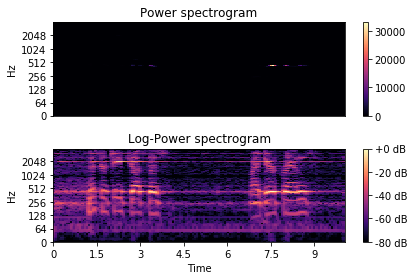

In [104]:
#音声プロット
#パワースペクトルと対数パワースペクトル
def plt_power_spec(S,sr):
  plt.figure()
  plt.subplot(2, 1, 1)
  librosa.display.specshow(S, sr=sr, y_axis='log')
  plt.colorbar()
  plt.title('Power spectrogram')
  plt.subplot(2, 1, 2)
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         sr=sr, y_axis='log', x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Log-Power spectrogram')
  plt.tight_layout()
  plt.show()

plt_power_spec(train_noisy_files[0],8000)

In [105]:
#griffin_limの確認（位相復元）
print(train_noisy_files[0].shape)
y=lc.griffinlim(train_noisy_files[0])
print(y.shape)
ipd.Audio(data=y,rate=8000)


(513, 157)
(39936,)


In [121]:

#print(len(x_train))  
freq = 513
time = 157

train_num = 5
test_num = 1

#型の変更
x_train = np.zeros(freq*time*train_num*len(train_files)).reshape(train_num*len(train_files), freq, time)
x_train_noisy=np.zeros(freq*time*train_num*len(train_noisy_files)).reshape(train_num*len(train_noisy_files), freq, time)


print(x_train.shape)
print(x_train_noisy.shape)

(25, 513, 157)
(25, 513, 157)


In [122]:

for i in range(len(train_files)):
  x_train[i*train_num:(i+1)*train_num] = train_files
  x_train_noisy[i*train_num:(i+1)*train_num] =  train_noisy_files

# CNN用にデータを(batch_size, freq, time, 1)にreshape    
x_train_re=x_train.reshape(train_num*len(train_files), freq, time, 1)
x_train_noisy_re=x_train_noisy.reshape(len(train_files)*train_num, freq, time, 1)
print(x_train_re.shape)
print(x_train_noisy_re.shape)
x_train=x_train.transpose(1,2,0)
x_train_noisy=x_train_noisy.transpose(1,2,0)
print(x_train.shape)
print(x_train_noisy.shape)

(25, 513, 157, 1)
(25, 513, 157, 1)
(513, 157, 25)
(513, 157, 25)


In [0]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten,Reshape,MaxPooling2D,UpSampling2D
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint

# DNCNN
input_img = Input(shape=(513, 157, 1))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = Activation('relu')(x)

for i in range(15):
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2D(1, (3, 3), padding='same')(x)
output_img = Activation('tanh')(x)

# compile
model = Model(input_img, output_img)
model.compile(optimizer='adam', loss='mean_squared_error')



In [125]:

x_val = x_train_re[20:,:,:,:]
x_noisy_val =x_train_noisy_re[20:,:,:,:]
print(x_val.shape)
print(x_noisy_val.shape)

(5, 513, 157, 1)
(5, 513, 157, 1)


In [126]:

model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 513, 157, 1)       0         
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 513, 157, 64)      640       
_________________________________________________________________
activation_134 (Activation)  (None, 513, 157, 64)      0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 513, 157, 64)      36928     
_________________________________________________________________
batch_normalization_120 (Bat (None, 513, 157, 64)      256       
_________________________________________________________________
activation_135 (Activation)  (None, 513, 157, 64)      0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 513, 157, 64)      3692

In [127]:
# options
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'howling_canceller_dncnn_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, mode='auto')
# train
history = model.fit(x_train_noisy_re,x_train_re,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val , x_noisy_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=False)

Train on 25 samples, validate on 5 samples
Epoch 1/100
25/25 [==============================] - 13s 524ms/step - loss: 6085.7562 - val_loss: 50589.4688

Epoch 00001: saving model to /content/howling_cancellerAutoEncoder_Cifar10_dncnn_weights.01-6085.76-50589.47.hdf5
Epoch 2/100
25/25 [==============================] - 6s 235ms/step - loss: 6076.5734 - val_loss: 50589.7695

Epoch 00002: saving model to /content/howling_cancellerAutoEncoder_Cifar10_dncnn_weights.02-6076.57-50589.77.hdf5
Epoch 3/100
25/25 [==============================] - 6s 232ms/step - loss: 6075.9581 - val_loss: 50589.4258

Epoch 00003: saving model to /content/howling_cancellerAutoEncoder_Cifar10_dncnn_weights.03-6075.96-50589.43.hdf5
Epoch 4/100
25/25 [==============================] - 6s 231ms/step - loss: 6075.9252 - val_loss: 50589.1250

Epoch 00004: saving model to /content/howling_cancellerAutoEncoder_Cifar10_dncnn_weights.04-6075.93-50589.12.hdf5
Epoch 5/100
25/25 [==============================] - 6s 231ms/st

In [137]:
#test
how_cancel=[]
how_cancel=model.predict(x_train_noisy_re)
print(how_cancel[0])


[[[ 0.19689097]
  [-0.0548597 ]
  [ 0.01364827]
  ...
  [ 0.0331342 ]
  [ 0.03583478]
  [-0.00701827]]

 [[ 0.17304951]
  [-0.1547267 ]
  [-0.15926102]
  ...
  [-0.09269905]
  [ 0.00193746]
  [-0.09917853]]

 [[ 0.18317938]
  [-0.11598634]
  [-0.06203178]
  ...
  [-0.05682571]
  [-0.01720465]
  [-0.0524056 ]]

 ...

 [[ 0.20558852]
  [-0.0975273 ]
  [-0.03530425]
  ...
  [-0.06525422]
  [-0.05206227]
  [ 0.00809616]]

 [[ 0.28835535]
  [ 0.06971126]
  [ 0.08444464]
  ...
  [ 0.04820968]
  [ 0.00808818]
  [ 0.00926109]]

 [[ 0.23102957]
  [ 0.10659008]
  [ 0.1362607 ]
  ...
  [ 0.08121684]
  [ 0.08970788]
  [ 0.00277428]]]


In [138]:
how_cancel_re= how_cancel[0].reshape(513,157*1)
how_cancel_gri=lc.griffinlim(how_cancel_re)
ipd.Audio(data=how_cancel_gri,rate=8000)